In [33]:
from dataclasses import dataclass, replace
from typing import Sequence

import jax
import jax.numpy as jnp
import jax.random as jr
from jax import vmap

import numpy as np
from flax import linen as nn
from flax.training import train_state
import optax
import orbax.checkpoint as ocp
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.collections import LineCollection

### Mixture of Gaussians

First we're going to generate a mixture of two Gaussians that the generator is supposed to match

In [3]:
def pmf_gaussian_single(
    mu: float,
    sigma: float,
    n_pixels: int = 784,
):
    """
    Discrete Gaussian over 784 bins
    Uses probability densities at bin centres rather than 
    integrated probability masses over the bin intervals
    """
    pixel_midpoints = jnp.arange(n_pixels) + 0.5
    pixel_frequencies = jnp.exp(-0.5 * ((pixel_midpoints - mu) / sigma) ** 2)
    pixel_probabilities = pixel_frequencies / pixel_frequencies.sum()
    return pixel_probabilities

In [4]:
def pmf_gaussian_mixed(
    mu1: float,
    sigma1: float,
    mu2: float,
    sigma2: float,
    alpha: float,
    n_pixels: int = 784,
):
    """pmf for α*N(mean1, std1) + (1-α)*N(mean2, std2) on discrete bins."""
    p1 = pmf_gaussian_single(mu1, sigma1, n_pixels)
    p2 = pmf_gaussian_single(mu2, sigma2, n_pixels)
    probs = alpha * p1 + (1.0 - alpha) * p2
    return probs 

In [5]:
def r_gaussian_mixed(
    key,
    mu1: float,
    sigma1: float,
    mu2: float,
    sigma2: float,
    alpha: float,
    n_pixels: int = 784,
    n_samples: int = 100,
    n_training_samples: int = 10,
):
    """Draw histograms from the 2-Gaussian mixture.

    Returns an array of shape (n_training_samples, n_pixels), where each row
    is a histogram (normalized to sum to 1) from `n_samples` draws.
    """
    probs = pmf_gaussian_mixed(mu1, sigma1, mu2, sigma2, alpha, n_pixels)
    probs = jnp.broadcast_to(probs, (n_training_samples, n_pixels))
    counts = jr.multinomial(key, n=n_samples, p=probs)
    return counts / n_samples
    

In [6]:
class MLP(nn.Module):
    layer_sizes: Sequence[int]

    @nn.compact
    def __call__(self, activations):
        for layer_number, layer_size in enumerate(self.layer_sizes):
            activations = nn.Dense(
                layer_size,
                kernel_init=nn.initializers.normal(0.1),
                bias_init=nn.initializers.normal(0.1)
            )(activations)

            if layer_number != (len(self.layer_sizes) - 1):
                activations = nn.relu(activations)

        return activations

In [7]:
class LowRankDense(nn.Module):
    """Low-rank dense layer implemented with two factors and einsum.

    Parameters are U in R^{in_features x rank} and V in R^{rank x features}.
    The forward pass computes y = (x @ U) @ V + b using einsum.
    """
    features: int
    rank: int
    use_bias: bool = True

    @nn.compact
    def __call__(self, inputs):
        # inputs: [batch, in_features]
        in_features = inputs.shape[-1]

        U = self.param(
            "U",
            nn.initializers.normal(0.1),
            (in_features, self.rank),
        )
        V = self.param(
            "V",
            nn.initializers.normal(0.1),
            (self.rank, self.features),
        )

        hidden = jnp.einsum("bi,ir->br", inputs, U)
        y = jnp.einsum("br,rf->bf", hidden, V)

        if self.use_bias:
            bias = self.param(
                "bias",
                nn.initializers.normal(0.1),
                (self.features,),
            )
            y = y + bias

        return y


class LowRankMLP(nn.Module):
    """
    Every layer uses the same low-rank dimension rank (="rank")
    """
    layer_sizes: Sequence[int]
    rank: int

    @nn.compact
    def __call__(self, activations):
        for layer_number, layer_size in enumerate(self.layer_sizes):
            activations = LowRankDense(
                features=layer_size,
                rank=self.rank,
                use_bias=True,
            )(activations)

            if layer_number != (len(self.layer_sizes) - 1):
                activations = nn.relu(activations)

        return activations

In [8]:
def initialise_network_params(model, input_layer_size, key):
    """Initialize all layers for a fully-connected neural network"""
    input_shape_dummy = jnp.ones((1, input_layer_size))
    params = model.init(key, input_shape_dummy)["params"]
    return params

In [9]:
def create_training_state(layer_sizes, optimizer, key, use_lowrank: bool = False, rank: int | None = None):
    input_layer_size = layer_sizes[0]
    network_layer_sizes = layer_sizes[1:]

    if use_lowrank:
        if rank is None:
            raise ValueError("rank must be provided when use_lowrank=True")
        model = LowRankMLP(layer_sizes=network_layer_sizes, rank=rank)
    else:
        model = MLP(layer_sizes=network_layer_sizes)

    apply_fn = model.apply
    params = initialise_network_params(model, input_layer_size, key)
    training_state = train_state.TrainState.create(
        apply_fn=apply_fn,
        params=params,
        tx=optimizer,
    )
    return training_state

In [10]:
def cross_entropy_loss_single_label(logits, label):
    targets = jnp.full_like(logits, label)
    return optax.sigmoid_binary_cross_entropy(logits, targets).mean()

def generator_loss_nonsaturating(logits_real_given_fake):
    """Objective: maximise p(predicted real | fake)"""
    return + cross_entropy_loss_single_label(logits=logits_real_given_fake, label=1)

def generator_loss_saturating(logits_real_given_fake):
    """Objective: minimise p(predicted fake | fake)"""
    return - cross_entropy_loss_single_label(logits=logits_real_given_fake, label=0)

def discriminator_loss(logits_real_given_real, logits_real_given_fake):
    loss_given_real = cross_entropy_loss_single_label(logits=logits_real_given_real, label=1)
    loss_given_fake = cross_entropy_loss_single_label(logits=logits_real_given_fake, label=0)
    return (loss_given_real + loss_given_fake) / 2

In [11]:
def calculate_generator_loss(
    generator_params,
    discriminator_params,
    generator_apply_fn,
    discriminator_apply_fn,
    z_vector,
    loss_type: str = "nonsaturating",
):
    fake_logits = generator_apply_fn({"params": generator_params}, z_vector)
    fake_images = nn.softmax(fake_logits, axis=-1)

    logits_real_given_fake = discriminator_apply_fn({"params": discriminator_params}, fake_images)
    if loss_type == "nonsaturating":
        return generator_loss_nonsaturating(logits_real_given_fake)
    elif loss_type == "saturating":
        return generator_loss_saturating(logits_real_given_fake)
    else:
        raise ValueError(f"incorrect loss type specified: {loss_type}")


def calculate_discriminator_loss(
    discriminator_params,
    generator_params,
    generator_apply_fn,
    discriminator_apply_fn,
    z_vector,
    real_images,
):
    fake_logits = generator_apply_fn({"params": generator_params}, z_vector)
    fake_images = nn.softmax(fake_logits, axis=-1)

    logits_real_given_fake = discriminator_apply_fn({"params": discriminator_params}, fake_images)
    logits_real_given_real = discriminator_apply_fn({"params": discriminator_params}, real_images)
    return discriminator_loss(logits_real_given_real, logits_real_given_fake)

In [12]:
@jax.jit
def take_generator_step_nonsaturating(generator, discriminator, z_vector):
    grads_by_params_fn = jax.grad(calculate_generator_loss)
    grads_by_params = grads_by_params_fn(
        generator.params,
        discriminator.params,
        generator.apply_fn,
        discriminator.apply_fn,
        z_vector,
        "nonsaturating",
    )
    return generator.apply_gradients(grads=grads_by_params)


@jax.jit
def take_generator_step_saturating(generator, discriminator, z_vector):
    grads_by_params_fn = jax.grad(calculate_generator_loss)
    grads_by_params = grads_by_params_fn(
        generator.params,
        discriminator.params,
        generator.apply_fn,
        discriminator.apply_fn,
        z_vector,
        "saturating",
    )
    return generator.apply_gradients(grads=grads_by_params)


@jax.jit
def take_discriminator_step(generator, discriminator, z_vector, real_images):
    grads_by_params_fn = jax.grad(calculate_discriminator_loss)
    grads_by_params = grads_by_params_fn(
        discriminator.params,
        generator.params,
        generator.apply_fn,
        discriminator.apply_fn,
        z_vector,
        real_images,
    )
    return discriminator.apply_gradients(grads=grads_by_params)

In [13]:
def subsample_images_for_batch(key, images_full_sample, batch_size):
    image_ids = jax.random.randint(key, (batch_size,), 0, images_full_sample.shape[0])
    return images_full_sample[image_ids]

In [ ]:
@dataclass(frozen=True)
class BimodalRunConfig:
    learning_rate: float = 1e-3
    n_steps: int = 5_000
    steps_per_save: int = 250
    max_to_keep: int | None = 100
    seed: int = 0
    batch_size: int = 128
    latent_dim: int = 64
    loss_type: str = "nonsaturating"

    def make_optimizer(self):
        return optax.adam(self.learning_rate)

    def make_key(self):
        return jax.random.key(self.seed)


def make_bimodal_experiment_name(config: BimodalRunConfig) -> str:
    """Checkpoint folder name for bimodal (2-Gaussian) runs."""
    return (
        f"gan_bimodal_latent_dim={config.latent_dim}_learning_rate={config.learning_rate}"
    )


def initialise_checkpoint_manager(
    experiment_name: str = "gan",
    max_to_keep: int | None = 100,
):
    project_root = Path().resolve()
    base_dir = project_root / "checkpoints"
    checkpoint_dir = base_dir / experiment_name
    checkpoint_dir.mkdir(parents=True, exist_ok=True)
    checkpoint_manager = ocp.CheckpointManager(
        directory=str(checkpoint_dir),
        options=ocp.CheckpointManagerOptions(max_to_keep=max_to_keep),
    )
    return checkpoint_manager

In [15]:
def run_training_gan(
    train_data,
    n_steps,
    generator_training_state,
    discriminator_training_state,
    key,
    config: BimodalRunConfig,
    checkpoint_manager,
    start_step: int = 0,
):
    """Train a GAN using random mini-batches of real images.

    Shapes:
      - train_data:          (N, n_pixels)
      - real_images_batch:  (config.batch_size, n_pixels)
      - z_vectors:          (config.batch_size, config.latent_dim)

    Args:
      start_step: starting global step index (for resuming from checkpoints).
    """
    real_images = train_data

    # Safety: don't overwrite existing checkpoints if you accidentally reuse a step.
    existing_steps = set(checkpoint_manager.all_steps())

    if config.loss_type == "nonsaturating":
        take_generator_step = take_generator_step_nonsaturating
    elif config.loss_type == "saturating":
        take_generator_step = take_generator_step_saturating
    else:
        raise ValueError(f"Unknown loss_type: {config.loss_type}")

    for step in range(1, n_steps + 1):
        key, key_z_generation, key_real_subsample = jax.random.split(key, 3)

        # Random mini-batch of real images
        real_images_batch = subsample_images_for_batch(
            key_real_subsample,
            real_images,
            config.batch_size,
        )

        # Latent vectors for generator
        z_vectors = jax.random.normal(
            key_z_generation,
            (config.batch_size, config.latent_dim),
        )

        # Update discriminator then generator
        discriminator_training_state = take_discriminator_step(
            generator_training_state,
            discriminator_training_state,
            z_vectors,
            real_images_batch,
        )
        generator_training_state = take_generator_step(
            generator_training_state,
            discriminator_training_state,
            z_vectors,
        )

        # Monitor losses
        generator_loss_value = calculate_generator_loss(
            generator_training_state.params,
            discriminator_training_state.params,
            generator_training_state.apply_fn,
            discriminator_training_state.apply_fn,
            z_vectors,
            loss_type=config.loss_type,
        )
        discriminator_loss_value = calculate_discriminator_loss(
            discriminator_training_state.params,
            generator_training_state.params,
            generator_training_state.apply_fn,
            discriminator_training_state.apply_fn,
            z_vectors,
            real_images_batch,
        )

        global_step = start_step + step

        # Print at the same cadence as checkpoint saving.
        if step == 1 or global_step % config.steps_per_save == 0:
            print(
                f"step {global_step}: generator_loss={generator_loss_value}, "
                f"discriminator_loss={discriminator_loss_value}"
            )
            if global_step in existing_steps:
                raise ValueError(
                    f"Refusing to overwrite existing checkpoint at step={global_step}. "
                    f"(start_step={start_step}; steps_per_save={config.steps_per_save})"
                )
            checkpoint_manager.save(
                global_step,
                args=ocp.args.StandardSave(
                    {
                        "generator": generator_training_state,
                        "discriminator": discriminator_training_state,
                    }
                ),
            )
            existing_steps.add(global_step)

    return generator_training_state, discriminator_training_state, key

In [16]:
def sample_batch(images, labels, n_batches):
    """Drops the last set of samples if they're not the right length"""
    n_samples = len(images)
    assert len(images) == len(labels)
    assert n_samples >= n_batches
    assert n_batches > 0
    n_samples_per_batch = n_samples // n_batches
    start = 0
    end = n_samples_per_batch
    while end <= n_samples: 
        yield (images[start:end], labels[start:end])
        start += n_samples_per_batch
        end += n_samples_per_batch

In [17]:
def setup_gan_training(optimizer, key, latent_dim):
    N_PIXELS = 784
    N_HIDDEN_LAYER = 128
    N_BINARY_CATEGORIES = 1

    # Generator maps from latent space (latent_dim) to image space (N_PIXELS)
    layer_sizes_generator = [latent_dim, N_HIDDEN_LAYER, N_PIXELS]
    layer_sizes_discriminator = [N_PIXELS, N_HIDDEN_LAYER, N_BINARY_CATEGORIES]

    g_key, d_key = jax.random.split(key)
    generator_training_state = create_training_state(layer_sizes_generator, optimizer, g_key)
    discriminator_training_state = create_training_state(layer_sizes_discriminator, optimizer, d_key)
    return generator_training_state, discriminator_training_state, key

In [18]:
def train_gan(
    train_data,
    optimizer,
    config: BimodalRunConfig,
    key=None,
):
    if key is None:
        key = config.make_key()

    experiment_name = make_bimodal_experiment_name(config)
    checkpoint_manager = initialise_checkpoint_manager(
        experiment_name,
        max_to_keep=config.max_to_keep,
    )

    generator_training_state, discriminator_training_state, key = setup_gan_training(
        optimizer=optimizer,
        key=key,
        latent_dim=config.latent_dim,
    )

    generator_training_state, discriminator_training_state, key = run_training_gan(
        train_data=train_data,
        n_steps=config.n_steps,
        generator_training_state=generator_training_state,
        discriminator_training_state=discriminator_training_state,
        key=key,
        config=config,
        checkpoint_manager=checkpoint_manager,
    )
    return generator_training_state, discriminator_training_state, key

In [19]:
# train_data = prepare_data(mnist_data["train"], subsample_size=10**4) 
# test_data = prepare_data(mnist_data["test"], subsample_size=10**3) 

In [20]:
key = jr.key(0)
n_training_samples = 10_000
n_pixels = 784
n_samples = 10_000

mu1 = 200
sigma1 = 50
mu2 = 350
sigma2 = 50 
alpha = 0.5
train_data = r_gaussian_mixed(key, mu1, sigma1, mu2, sigma2, alpha, n_pixels, n_samples, n_training_samples)

W0108 16:45:50.967877   15535 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W0108 16:45:50.977291    4054 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


In [29]:
config = BimodalRunConfig(
    learning_rate=1e-3,
    n_steps=5_000,
    steps_per_save=250,
    seed=0,
    batch_size=128,
    latent_dim=64,
    loss_type="nonsaturating",
)

optimizer = config.make_optimizer()
key = config.make_key()

# Backwards-compatible convenience vars (optional)
learning_rate = config.learning_rate
n_steps = config.n_steps
steps_per_save = config.steps_per_save
seed = config.seed
batch_size = config.batch_size
latent_dim = config.latent_dim
loss_type = config.loss_type

In [26]:
def plot_real_vs_generated_histogram_from_last_checkpoint(
    train_data,
    optimizer,
    config: BimodalRunConfig,
    y_max: float = 0.02,
):
    """Plot one real histogram and one generated histogram from last checkpoint.

    Restores the generator from the latest checkpoint for this bimodal run
    and plots a single real vs generated histogram.
    """
    experiment_name = make_bimodal_experiment_name(config)
    ckpt_manager = initialise_checkpoint_manager(experiment_name)
    steps = sorted(ckpt_manager.all_steps())
    if not steps:
        raise ValueError(
            f"No checkpoints found for experiment_name={experiment_name!r}."
        )

    gen_tmpl, disc_tmpl, _ = setup_gan_training(
        optimizer=optimizer,
        key=jax.random.key(0),
        latent_dim=config.latent_dim,
    )
    restored = ckpt_manager.restore(
        steps[-1],
        args=ocp.args.StandardRestore(
            item={"generator": gen_tmpl, "discriminator": disc_tmpl}
        ),
    )
    generator_for_plot = restored["generator"]

    key = jax.random.key(0)
    key, z_key, real_key = jax.random.split(key, 3)

    z = jax.random.normal(z_key, (1, config.latent_dim))

    # The generator outputs *logits*; keep plotting consistent with training.
    fake_logits = generator_for_plot.apply_fn(
        {"params": generator_for_plot.params},
        z,
    )[0]
    fake_hist = nn.softmax(fake_logits, axis=-1)

    real_idx = jax.random.randint(
        real_key, shape=(), minval=0, maxval=train_data.shape[0]
    )
    real_hist = train_data[real_idx]

    # Convert to NumPy for plotting
    fake_hist_np = np.array(fake_hist)
    real_hist_np = np.array(real_hist)

    plt.figure(figsize=(8, 4))
    plt.plot(real_hist_np, label="Real histogram")
    plt.plot(fake_hist_np, label="Generated histogram")
    plt.xlabel("Bin index")
    plt.ylabel("Probability (normalized)")
    plt.ylim(top=y_max)
    plt.title("Real vs Generated Histogram")
    plt.legend()
    plt.tight_layout()
    plt.show()



In [28]:
def plot_gan_loss_trajectory_from_checkpoints(
    train_data,
    optimizer,
    config: BimodalRunConfig,
    burn_in_steps: int = 1_000,
):
    """Reload checkpoints for this notebook's run and plot D vs G loss.

    Uses the same naming convention as `train_gan` and evaluates losses
    at each saved checkpoint on a fresh mini-batch from `train_data`.

    Args:
      burn_in_steps: ignore checkpoints with global step < burn_in_steps.
        Set to 0 to disable burn-in.
    """
    experiment_name = make_bimodal_experiment_name(config)
    ckpt_manager = initialise_checkpoint_manager(experiment_name)

    all_steps = sorted(ckpt_manager.all_steps())
    if not all_steps:
        print(f"No checkpoints found for experiment_name={experiment_name!r}.")
        return

    steps = all_steps
    if burn_in_steps and burn_in_steps > 0:
        steps = [s for s in all_steps if s >= burn_in_steps]
        if not steps:
            print(
                f"All checkpoints are before burn_in_steps={burn_in_steps} "
                f"(available steps: [{all_steps[0]}, {all_steps[-1]}])."
            )
            return

    # Template states for restoring checkpoints
    gen_tmpl, disc_tmpl, _ = setup_gan_training(
        optimizer=optimizer,
        key=jax.random.key(0),
        latent_dim=config.latent_dim,
    )

    g_losses = []
    d_losses = []

    for step in steps:
        restored = ckpt_manager.restore(
            step,
            args=ocp.args.StandardRestore(
                item={"generator": gen_tmpl, "discriminator": disc_tmpl}
            ),
        )
        gen_state = restored["generator"]
        disc_state = restored["discriminator"]

        # Use a fresh key for evaluation at each checkpoint
        key_eval = jax.random.key(0)
        key_eval, key_z, key_real = jax.random.split(key_eval, 3)

        z_vectors = jax.random.normal(key_z, (config.batch_size, config.latent_dim))
        real_images_batch = subsample_images_for_batch(
            key_real, train_data, config.batch_size
        )

        g_loss = calculate_generator_loss(
            gen_state.params,
            disc_state.params,
            gen_state.apply_fn,
            disc_state.apply_fn,
            z_vectors,
            loss_type=config.loss_type,
        )
        d_loss = calculate_discriminator_loss(
            disc_state.params,
            gen_state.params,
            gen_state.apply_fn,
            disc_state.apply_fn,
            z_vectors,
            real_images_batch,
        )

        g_losses.append(float(g_loss))
        d_losses.append(float(d_loss))

    # Convert to NumPy arrays for plotting
    g = np.array(g_losses)
    d = np.array(d_losses)

    fig, ax = plt.subplots(figsize=(6, 6))
    points = np.column_stack([d, g])  # x: discriminator, y: generator

    if len(points) > 1:
        segments = np.stack([points[:-1], points[1:]], axis=1)
        t = np.linspace(0.0, 1.0, len(points) - 1)
        colors = cm.coolwarm(t)

        lc = LineCollection(segments, colors=colors, linewidths=1.5)
        ax.add_collection(lc)

    # Scatter the points (including first/last)
    ax.scatter(
        points[:, 0],
        points[:, 1],
        c=np.linspace(0.0, 1.0, len(points)),
        cmap="coolwarm",
        s=12,
        alpha=0.8,
    )

    if len(points) > 0:
        ax.scatter(points[0, 0], points[0, 1], color="blue", s=60, label="start")
        ax.scatter(points[-1, 0], points[-1, 1], color="red", s=60, label="end")

    ax.set_xlabel("Discriminator loss")
    ax.set_ylabel("Generator loss")
    title = f"GAN training dynamics in loss space ({config.loss_type})"
    if burn_in_steps and burn_in_steps > 0:
        title += f" (burn-in: {burn_in_steps})"
    ax.set_title(title)
    ax.grid(True)
    ax.legend()
    plt.tight_layout()
    plt.show()


## Training

In [ ]:
generator_training_state, discriminator_training_state, key = train_gan(
    train_data=train_data,
    optimizer=optimizer,
    config=config,
    key=key,
)


step 1: generator_loss=0.6642202138900757, discriminator_loss=0.6921238899230957
step 250: generator_loss=1.4984166622161865, discriminator_loss=0.27475467324256897
step 500: generator_loss=5.140908241271973, discriminator_loss=0.009015464223921299
step 750: generator_loss=6.239480018615723, discriminator_loss=0.002869744086638093
step 1000: generator_loss=1.4418976306915283, discriminator_loss=0.2807518243789673
step 1250: generator_loss=0.6093816757202148, discriminator_loss=0.7646958231925964
step 1500: generator_loss=0.9833340644836426, discriminator_loss=0.4698827862739563
step 1750: generator_loss=0.7987109422683716, discriminator_loss=0.5992294549942017
step 2000: generator_loss=0.7498448491096497, discriminator_loss=0.6404880285263062
step 2250: generator_loss=0.7226254940032959, discriminator_loss=0.6687623262405396
step 2500: generator_loss=0.7000272274017334, discriminator_loss=0.6841363906860352
step 2750: generator_loss=0.7603437304496765, discriminator_loss=0.634654998779

In [ ]:
g_state, d_state, key, resume_config = resume_gan_training_from_latest_checkpoint(
    train_data=train_data,
    base_config=config,
    extra_steps=5_000,
    resume_seed=1,
)

Resuming training from global step 5000 (experiment_name='gan_bimodal_latent_dim=64_learning_rate=0.001')
step 5001: generator_loss=0.7137051820755005, discriminator_loss=0.6676926016807556
step 5250: generator_loss=0.7155618071556091, discriminator_loss=0.6601847410202026
step 5500: generator_loss=0.6698465347290039, discriminator_loss=0.7229334115982056
step 5750: generator_loss=0.6477502584457397, discriminator_loss=0.7295362949371338
step 6000: generator_loss=0.7799390554428101, discriminator_loss=0.612951934337616
step 6250: generator_loss=0.7009996175765991, discriminator_loss=0.6813268065452576
step 6500: generator_loss=0.6970445513725281, discriminator_loss=0.6897774934768677
step 6750: generator_loss=0.6960781812667847, discriminator_loss=0.6916316747665405
step 7000: generator_loss=0.6905195713043213, discriminator_loss=0.6931061744689941
step 7250: generator_loss=0.6280848383903503, discriminator_loss=0.7601876258850098
step 7500: generator_loss=0.6823364496231079, discrimin

## Extended training

In [34]:
def resume_gan_training_from_latest_checkpoint(
    train_data,
    base_config: BimodalRunConfig,
    *,
    extra_steps: int,
    resume_seed: int = 1,
    optimizer=None,
    key=None,
    start_step: int | None = None,  # override if you don't want "latest"
):
    """
    Resume training for the run identified by `make_bimodal_experiment_name(base_config)`.
    Note: in this notebook that name depends only on (latent_dim, learning_rate).
    """
    resume_config = BimodalRunConfig(
        learning_rate=base_config.learning_rate,
        n_steps=extra_steps,
        steps_per_save=base_config.steps_per_save,
        max_to_keep=base_config.max_to_keep,
        seed=resume_seed,
        batch_size=base_config.batch_size,
        latent_dim=base_config.latent_dim,
        loss_type=base_config.loss_type,
    )

    if optimizer is None:
        optimizer = resume_config.make_optimizer()
    if key is None:
        key = resume_config.make_key()

    experiment_name = make_bimodal_experiment_name(resume_config)
    ckpt_manager = initialise_checkpoint_manager(
        experiment_name,
        max_to_keep=resume_config.max_to_keep,
    )
    steps = sorted(ckpt_manager.all_steps())
    if not steps:
        raise ValueError(f"No checkpoints found for experiment_name={experiment_name!r}.")

    last_step = steps[-1] if start_step is None else start_step
    print(f"Resuming training from global step {last_step} (experiment_name={experiment_name!r})")

    gen_tmpl, disc_tmpl, _ = setup_gan_training(
        optimizer=optimizer,
        key=jax.random.key(0),
        latent_dim=resume_config.latent_dim,
    )
    restored = ckpt_manager.restore(
        last_step,
        args=ocp.args.StandardRestore(item={"generator": gen_tmpl, "discriminator": disc_tmpl}),
    )
    g_state = restored["generator"]
    d_state = restored["discriminator"]

    g_state, d_state, key = run_training_gan(
        train_data=train_data,
        n_steps=resume_config.n_steps,
        generator_training_state=g_state,
        discriminator_training_state=d_state,
        key=key,
        config=resume_config,
        checkpoint_manager=ckpt_manager,
        start_step=last_step,
    )

    return g_state, d_state, key, resume_config

## Plot graphs 
(for all checkpoints in directory)

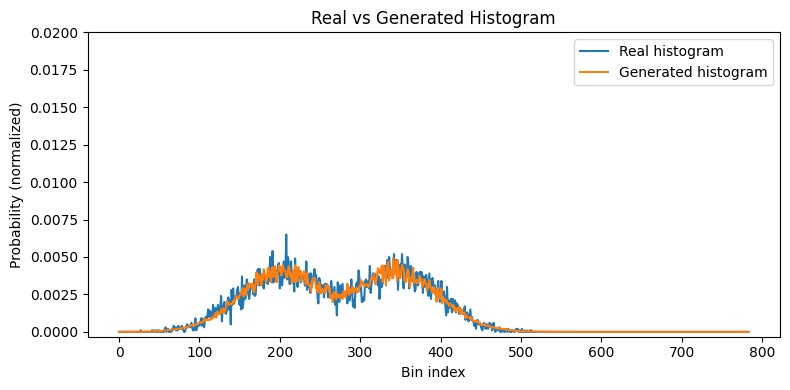

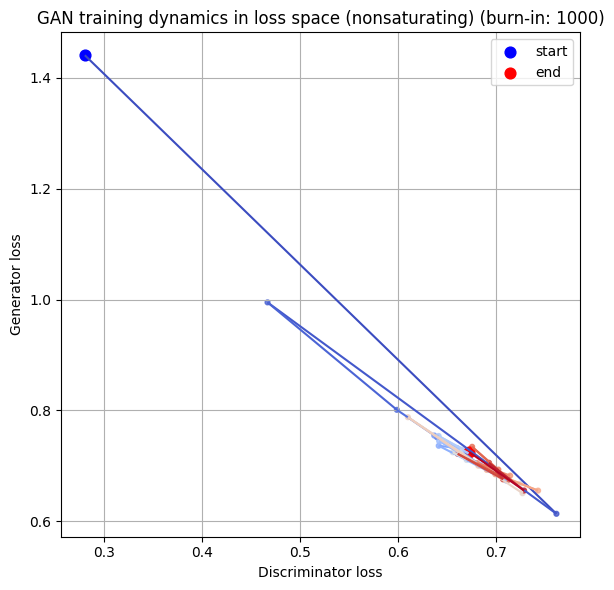

In [25]:
plot_real_vs_generated_histogram_from_last_checkpoint(
    train_data=train_data,
    optimizer=optimizer,
    config=config,
    y_max=0.02,
)

plot_gan_loss_trajectory_from_checkpoints(
    train_data=train_data,
    optimizer=optimizer,
    config=config,
    burn_in_steps=1_000,
)

## Representation experiment

How does neural network size affect convergence to the GAN Nash equilibrium?

In [ ]:
# here we're going to repeat the earlier experiment (up to 5000 iterations) but with a much much lower latent space dimension for the generator (but not the discriminator)

## Convergence experiment

How do learning rates affect convergence to the GAN Nash equilibrium?

In [36]:
small_latent_config = replace(config, latent_dim=4)

small_latent_optimizer = small_latent_config.make_optimizer()
small_latent_key = small_latent_config.make_key()

In [ ]:
print("Running:", make_bimodal_experiment_name(small_latent_config))

small_g_state, small_d_state, small_latent_key = train_gan(
    train_data=train_data,
    optimizer=small_latent_optimizer,
    config=small_latent_config,
    key=small_latent_key,
)

In [ ]:
plot_real_vs_generated_histogram_from_last_checkpoint(
    train_data=train_data,
    optimizer=small_latent_optimizer,
    config=small_latent_config,
    y_max=0.02,
)

plot_gan_loss_trajectory_from_checkpoints(
    train_data=train_data,
    optimizer=small_latent_optimizer,
    config=small_latent_config,
    burn_in_steps=1_000,
)

In [ ]:
# Resume small-latent model (latent_dim=4) from 5000 -> 10000
g_state, d_state, key, small_resume_config = resume_gan_training_from_latest_checkpoint(
    train_data=train_data,
    base_config=small_latent_config,
    extra_steps=5_000,
    resume_seed=1,
)

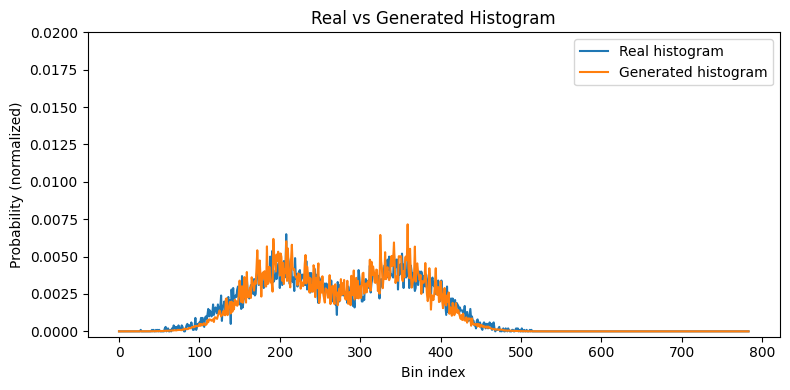

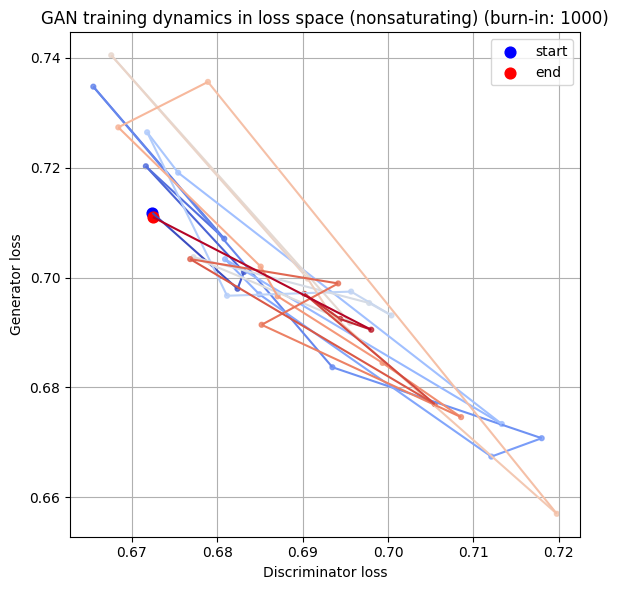

In [32]:
plot_real_vs_generated_histogram_from_last_checkpoint(
    train_data,
    optimizer=small_latent_config.make_optimizer(),
    config=small_latent_config,
    y_max=0.02,
)

plot_gan_loss_trajectory_from_checkpoints(
    train_data,
    optimizer=small_latent_config.make_optimizer(),
    config=small_latent_config,
    burn_in_steps=1_000,
)

## 1D latent space

In [37]:
one_latent_config = replace(config, n_steps=10_000, latent_dim=1)

In [38]:
one_latent_optimizer = one_latent_config.make_optimizer()
one_latent_key = one_latent_config.make_key()

print("Running:", make_bimodal_experiment_name(one_latent_config))

one_g_state, one_d_state, one_latent_key = train_gan(
    train_data=train_data,
    optimizer=one_latent_optimizer,
    config=one_latent_config,
    key=one_latent_key,
)

Running: gan_bimodal_latent_dim=1_learning_rate=0.001
step 1: generator_loss=0.6653502583503723, discriminator_loss=0.6915308833122253
step 250: generator_loss=0.6968159079551697, discriminator_loss=0.6895828247070312
step 500: generator_loss=0.8014451265335083, discriminator_loss=0.5962454080581665
step 750: generator_loss=0.7236156463623047, discriminator_loss=0.6723683476448059
step 1000: generator_loss=0.713890552520752, discriminator_loss=0.673164427280426
step 1250: generator_loss=0.7161576747894287, discriminator_loss=0.6695865392684937
step 1500: generator_loss=0.7080561518669128, discriminator_loss=0.6792224645614624
step 1750: generator_loss=0.727389395236969, discriminator_loss=0.6616064310073853
step 2000: generator_loss=0.7091764211654663, discriminator_loss=0.6747725009918213
step 2250: generator_loss=0.7125365734100342, discriminator_loss=0.6704912185668945
step 2500: generator_loss=0.710166335105896, discriminator_loss=0.6702455878257751
step 2750: generator_loss=0.7125

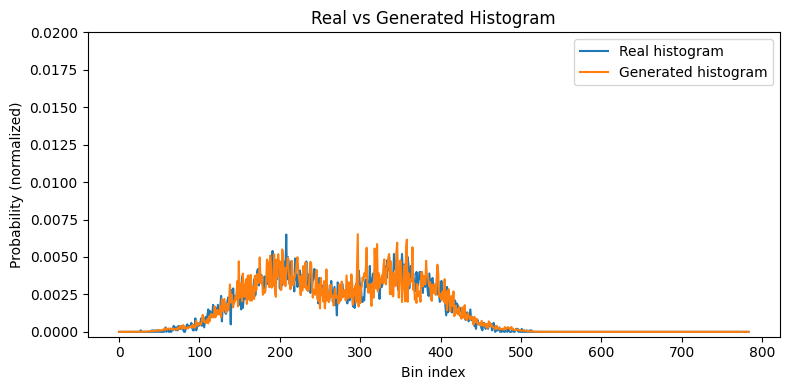

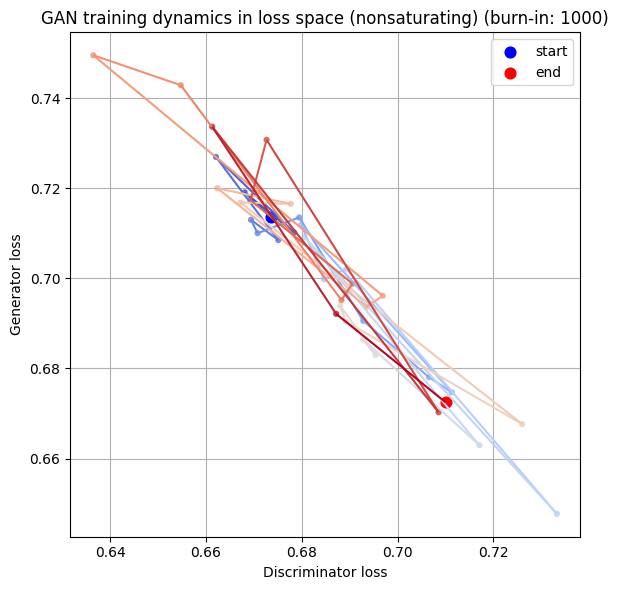

In [39]:
plot_real_vs_generated_histogram_from_last_checkpoint(
    train_data,
    optimizer=one_latent_config.make_optimizer(),
    config=one_latent_config,
    y_max=0.02,
)

plot_gan_loss_trajectory_from_checkpoints(
    train_data,
    optimizer=one_latent_config.make_optimizer(),
    config=one_latent_config,
    burn_in_steps=1_000,
)

## TODO: why does the generator do better with *fewer* latent dimensions?

1D > 4D > 64D